# Imaging module tutorial

This tutorial shows how to convert DICOM into NRRD, check ROI segmentation, extract the radiomic features, and explore the imaging parameters.

Importing modules:

In [3]:
import os,sys
sys.path.append(os.path.abspath(".."))
from tool_box import tool_box
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

%matplotlib inline

## Data download

The Lung1 dataset (Aerts et al., 2014) contains pretreatment scans of 422 non-small cell lung cancer (NSCLC) patients, as well as manually deliniated gross tumor volume (GTV) for each patient, and clinical outcomes. More information you can find on the dataset web page and in the corresponding paper https://doi.org/10.1038/ncomms5006. For consistency, we recommend you to download the data to the '../data/dcms' folder of this project. You can find the data and its description (and the original paper) following the link below:
https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics

To download the dataset, you might need to install the download manager: https://wiki.cancerimagingarchive.net/display/NBIA/Downloading+TCIA+Images#DownloadingTCIAImages-DownloadingtheNBIADataRetriever

Finally, you will have the '../data/dcms' folder with CT images (it will require 33 GB of disc space!).

##  DICOM to NRRD conversion

To convert DICOM dataset to the volume (nrrd) format, set up the parameters:  

* '*export_path = ...*' export path where the converted NRRDs will be placed,  
* '*region_of_interest = ...*' if you know exact name of the ROI you want to extract, then write it with the '!' character in front, eg. '*region_of_interest = !gtv1*',
* if you want to extract all the GTVs in the rtstruct eg. '*gtv1*', '*gtv2*', '*gtv_whatever*', then just specify the stem word, eg. '*region_of_interest = gtv*', 
* default value is '*region_of_interest ='all'*', where all ROI's in rtstruct will be extracted.

In [4]:
parameters = {'data_path': r'../data/dcms/', # path_to_your_DICOM_data
              'data_type': 'dcm', # original data format: DICOM
              'multi_rts_per_pat': False}   # when False, it will look only for 1 rtstruct in the patient folder, 
                                            # this will speed up the process, 
                                            # if you have more then 1 rtstruct per patient, set it to True
                  
export_path =r'../data/' # the function will create 'converted_nrrd' folder in the specified directory       

Initialize the dataset (originally downloaded directory with DICOM files):

In [5]:
data_ct = tool_box(**parameters) 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Run the conversion:

In [6]:
data_ct.convert_to_nrrd(export_path, 'gtv')

Patients converted: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.91s/it]


## Quick check of the ROI's in the NRRD dataset

If you want to check your converted images & ROIs, or just any volumetric dataset (NRRD/MHA), you can use get_jpegs function of the toolbox. It will generate JPEG images for each slice with the image and overlap of the contour.

Initialize the dataset (converted NRRD files):

In [10]:
data_ct_nrrd = tool_box(data_path = r'../data/converted_nrrds/', data_type='nrrd')

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2997.36it/s]


Run the visualization:

In [8]:
data_ct_nrrd.get_jpegs(r'../data/') # the function will create 'images_quick_check' folder in the specified directory 

Patients processed: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.13s/it]


Let's check one of the patients:

In [9]:
from ipywidgets import interact
import numpy as np
from PIL import Image

def browse_images(images,names):
    n = len(images)
    def view_image(i):
        plt.figure(figsize=(20,10))
        plt.imshow(images[i])#, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Slice: %s' % names[i])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))
    
for pat,_ in data_ct_nrrd:
    _,file_struct = [*os.walk(os.path.join('../data/images_quick_check/',pat))]
    root,images = file_struct[0],file_struct[2]
    imgs =[np.array(Image.open(os.path.join(root,img))) for img in images]
    print(pat)
    browse_images(imgs,images)
    break

LUNG1-001_20180209_CT_2_GTV-1_mask


interactive(children=(IntSlider(value=10, description='i', max=20), Output()), _dom_classes=('widget-interact'…

## PyRadiomics features extraction

In our toolbox, we are using PyRadiomics software (https://pyradiomics.readthedocs.io/en/latest/) to extract the features. You can read the full documentation for the currently stable version: https://pyradiomics.readthedocs.io/_/downloads/en/stable/pdf/.

Initialize the dataset (converted NRRD files):

In [11]:
data_ct_nrrd = tool_box(data_path = r'../data/converted_nrrds/',
                    data_type='nrrd')

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2999.50it/s]


We are using PyRadiomics parameters file customized for CT data:

In [12]:
parameters = r"example_ct_parameters.yaml"
features = data_ct_nrrd.extract_features(parameters, loggenabled=True)

Patients processed: 100%|████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.13s/it]


Printing the features for first 3 ROIs:

In [13]:
features.head(3)

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,wavelet-LLL_gldm_HighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceEmphasis,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,Patient,ROI
0,v3.0,1.18.5,1.2.0,1.1.1,3.7.1,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",01ae3d400f3f6fdacc121a85f52fd9dba8be2253,3D,"(0.9765625, 0.9765625, 3.0)",...,14462.536758039314,33.609142408868486,548084.071741353,0.0027591623386472087,0.00013875155227786726,0.2677613556442223,2959.5714944611627,5.8227784555678714e-05,LUNG1-001_20180209_CT_2_GTV-1_mask,GTV-1_mask
1,v3.0,1.18.5,1.2.0,1.1.1,3.7.1,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",5c66c70353901fd238191b88a2584cd8c3f645e5,3D,"(0.977, 0.977, 3.0)",...,13208.12549259126,55.600106536368784,832176.2485225748,0.004497426306875555,0.00016233377171621347,0.1889311894310745,1733.8368052732842,5.3429352136211716e-05,LUNG1-002_20180526_CT_1_GTV-1_mask,GTV-1_mask
2,v3.0,1.18.5,1.2.0,1.1.1,3.7.1,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",9a2b123cabcc00593e4255d41cbef78f0cb63630,3D,"(0.977, 0.977, 3.0)",...,9142.646956472132,17.90900792971647,209143.44409264647,0.0026732953405101414,0.0003673562141585293,0.4029303292416708,2838.784544208129,0.00019106863067788412,LUNG1-003_20180209_CT_1_GTV-1_mask,GTV-1_mask


Writing the features into the Excel file (you will find it in the 'data/features' folder):

In [14]:
writer = pd.ExcelWriter('../data/features/extracted_features.xlsx') 
features.to_excel(writer, 'Sheet1')
writer.save()

## Dataset exploration

Initialize the dataset:

In [16]:
parameters = {'data_path': r'../data/dcms/', #path_to_your_DICOM_data
              'data_type': 'dcm'}    
data_dcms = tool_box(**parameters)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.60it/s]


Get the default metainformation from the DICOM files and print first 10:

In [18]:
dataset_description = data_dcms.get_dataset_description() 
dataset_description.head(10)

Patients processed: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s]


,Modality,SliceThickness,PixelSpacing,SeriesDate,Manufacturer,patient,slice#
0,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,0
1,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,1
2,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,2
3,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,3
4,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,4
5,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,5
6,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,6
7,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,7
8,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,8
9,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,9


You can check for the needed info by printing unique values of the tags:

In [19]:
print('Unique modalities found: ', np.unique(dataset_description.Modality.values)[0])

Unique modalities found:  CT


There are two pre-set parameter dictionaries for 'CT' and 'MRI' with the extended amount of parameters, parsed from the DICOM tags. These parameters are specific for these imaging modalities. You can also send a custom list of parameters. In this case the DICOM tags should have the same names as corresponding pydicom (DICOM keyword, https://pydicom.github.io/pydicom/dev/old/base_element.html).

Get the CT-specific metainformation from the DICOM files and print first 10:

In [21]:
ct_dcms = tool_box(**parameters)
dataset_description = ct_dcms.get_dataset_description('CT') 
dataset_description.head(10)

Patients processed: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


,PatientName,ConvolutionKernel,SliceThickness,PixelSpacing,KVP,Exposure,XRayTubeCurrent,SeriesDate,patient,slice#
0,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,0
1,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,1
2,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,2
3,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,3
4,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,4
5,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,5
6,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,6
7,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,7
8,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,8
9,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,9


Let's plot some of the scans parameters:

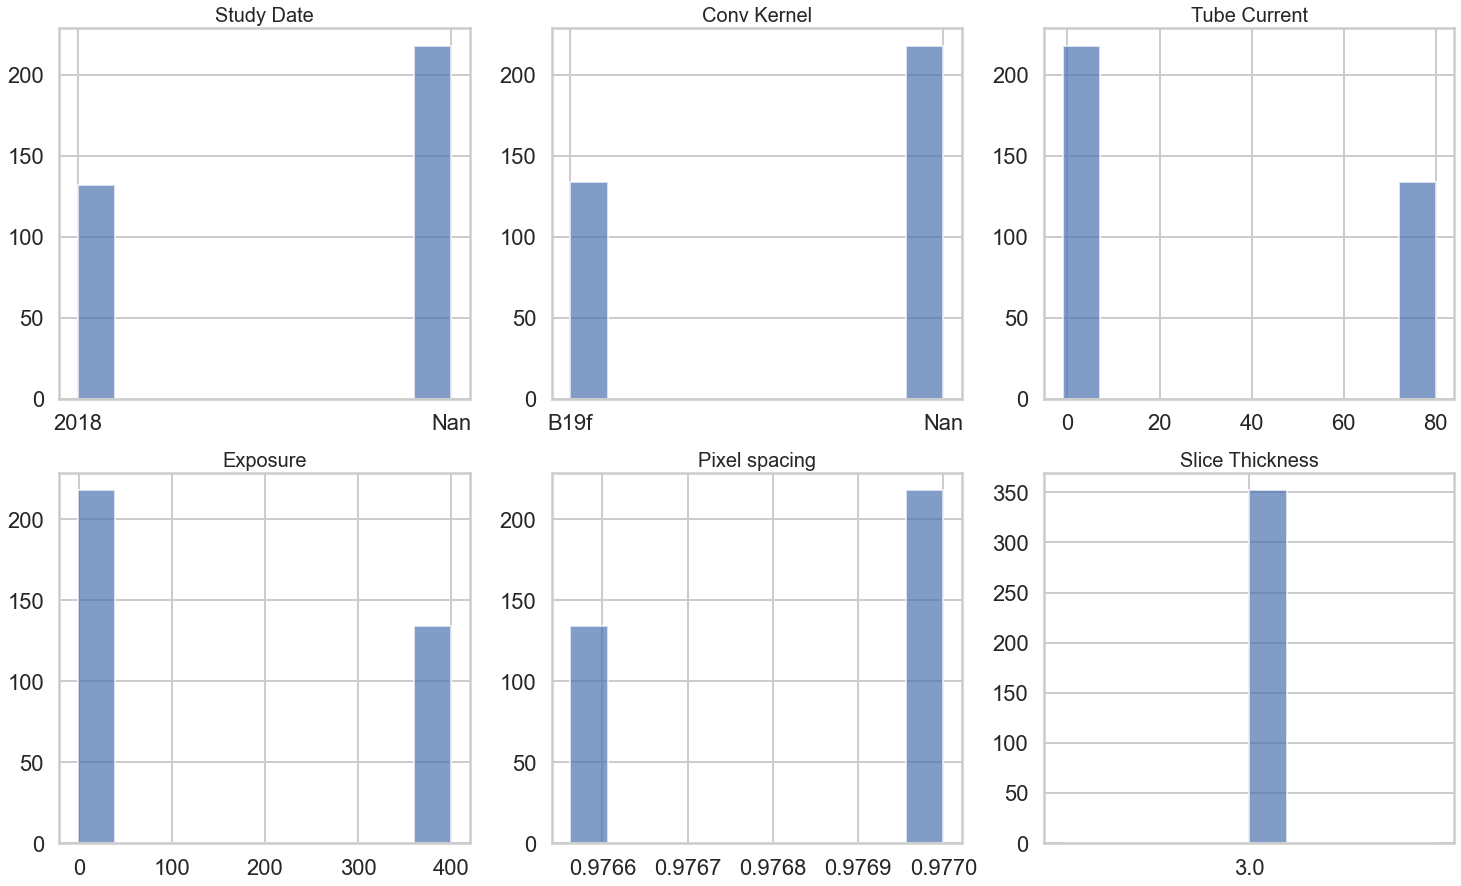

In [22]:
sb.set(context='poster', style='whitegrid')

study_date = sorted([ 'Nan' if x=='' or x=='NaN' else str(x[0:4]) for x in list(dataset_description['SeriesDate'])])[2:]
conv_kernel =['Nan' if x=='' or x=='NaN' else x for x in list(dataset_description['ConvolutionKernel'])]
tube_current =[-1 if x=='' or x=='NaN' else x for x in list(dataset_description['XRayTubeCurrent'])]
exposure =[-1 if x=='' or x=='NaN' else x for x in list(dataset_description['Exposure'])]
ps = sorted([(x[0]) for x in list(filter(lambda x: x != 'NaN', dataset_description['PixelSpacing'].values))])
sl_th = sorted([str(x)[0:3] for x in list(filter(lambda x: x != 'NaN', dataset_description['SliceThickness'].values))])
figures,descriptions = [study_date,conv_kernel,tube_current,exposure,ps,sl_th],['Study Date','Conv Kernel','Tube Current','Exposure','Pixel spacing','Slice Thickness']

fig,ax = plt.subplots(2,3,figsize=(25,15))
for i in range(2):
    for j in range(3):
        ax[i,j].hist(figures.pop(0),alpha=0.7)
        ax[i,j].set_title(descriptions.pop(0),fontsize=20)